In [1]:
%matplotlib notebook

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import gaussian_filter1d
from matplotlib.animation import FFMpegWriter, PillowWriter


C:\Users\osval\anaconda3\envs\Oz\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\osval\anaconda3\envs\Oz\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# These variables are accessed by the animate() function
_global = {
    "subset_df": None,           # Pandas DataFrame: smoothed weekly data for selected years
    "weeks": None,               # Week indices (1 to 52)
    "years_to_animate": None,    # List of years to be animated
    "num_weeks": None,           # Total number of weeks (usually 52)
    "active_line": None,         # Line object to update in animation
    "active_dots": None,         # Dot object to update in animation
    "ax": None                   # Axes object for updating the title
}

def generate_synthetic_ts_data(years, full_weeks=52):
    """
    Generates synthetic dengue case data for visualization and animation.
    Uses sinusoidal trends plus noise to simulate real-world seasonality.

    Parameters:
        years (list of int): Years to simulate (e.g., [2005, 2010, 2015])
        full_weeks (int): Number of weeks (default = 52)

    Returns:
        pd.DataFrame: Columns = [Year, Week, Cases]
    """
    np.random.seed(42)  # For reproducibility
    all_data = []

    for year in years:
        # Create seasonality with variable amplitude and frequency
        peak = np.random.randint(800, 2000)
        width = np.random.uniform(0.8, 1.2)
        base = np.sin(np.linspace(0, 2 * np.pi * width, full_weeks)) * peak
        noise = np.random.normal(loc=0, scale=150, size=full_weeks)
        trend = base + noise + np.random.randint(100, 400)
        trend = np.clip(trend, 0, None)  # Ensure no negative values

        for week in range(1, full_weeks + 1):
            all_data.append({
                'Year': year,
                'Week': week,
                'Cases': int(trend[week - 1])
            })

    return pd.DataFrame(all_data)


def animate(frame, week_step):
    """
    Animation update function for FuncAnimation.
    Updates the line and dot plot for each frame.

    Parameters:
        frame (int): Current frame index
        week_step (int): Step size for points shown (e.g. 2 = show every 2 weeks)

    Returns:
        Tuple of updated plot elements
    """
    year_idx = frame // _global["num_weeks"]
    week_idx = frame % _global["num_weeks"]

    if year_idx >= len(_global["years_to_animate"]):
        return _global["active_line"], _global["active_dots"]

    year = _global["years_to_animate"][year_idx]
    x = _global["weeks"][:week_idx + 1:week_step]
    y = _global["subset_df"][year].iloc[:week_idx + 1:week_step]

    _global["active_line"].set_data(x, y)
    _global["active_dots"].set_data(x, y)
    _global["ax"].set_title(f'TIme series values for year: {year}')
    return _global["active_line"], _global["active_dots"]


def animate_ts(data, years_to_animate, week_step=4):
    """
    Generates an animated line chart showing time series values year by year.

    Parameters:
        data (pd.DataFrame): Output of generate_synthetic_ts_data
        years_to_animate (list of int): Years to animate
        week_step (int): Interval to show points (e.g. 4 = show every 4 weeks)

    Returns:
        matplotlib.animation.FuncAnimation: The animation object
    """
    # Pivot data: rows = weeks, columns = years
    pivot_df = data.pivot(index='Week', columns='Year', values='Cases')

    # Apply smoothing to reduce noise
    smoothed_df = pivot_df.apply(lambda x: gaussian_filter1d(x, sigma=2), axis=0)

    # Ensure all 52 weeks are present in the index
    smoothed_df = smoothed_df.reindex(range(1, 53))

    # Extract only the selected years for animation
    subset_df = smoothed_df[years_to_animate]
    weeks = subset_df.index
    num_weeks = len(weeks)

    # === Plot Setup ===
    fig, ax = plt.subplots(figsize=(9, 6))

    # Static light grey background lines for each year
    for year in years_to_animate:
        ax.plot(weeks, subset_df[year], color='lightgrey', linewidth=1)

    # Black line and dots that will be animated
    active_line, = ax.plot([], [], color='black', linewidth=2)
    active_dots, = ax.plot([], [], 'o', color='black')

    # Axes formatting
    ax.set_xlim(1, 52)
    ax.set_ylim(0, subset_df.max().max() * 1.1)
    ax.set_xticks(range(1, 53, 2))  # Tick every 2 weeks
    ax.set_xlabel('Week of the Year')
    ax.set_ylabel('Time series values')
    ax.set_title('Animated Time Series Values Dynamics')
    ax.grid(True, linestyle='--', alpha=0.5)

    # Store global animation context
    _global.update({
        "subset_df": subset_df,
        "weeks": weeks,
        "years_to_animate": years_to_animate,
        "num_weeks": num_weeks,
        "active_line": active_line,
        "active_dots": active_dots,
        "ax": ax
    })

    # Total frames = number of weeks per year × number of years
    total_frames = num_weeks * len(years_to_animate)

    # Create animation object
    ani = animation.FuncAnimation(
        fig,
        func=lambda frame: animate(frame, week_step),
        frames=total_frames,
        interval=150,
        blit=True,
        repeat=False
    )

    return ani

<IPython.core.display.Javascript object>


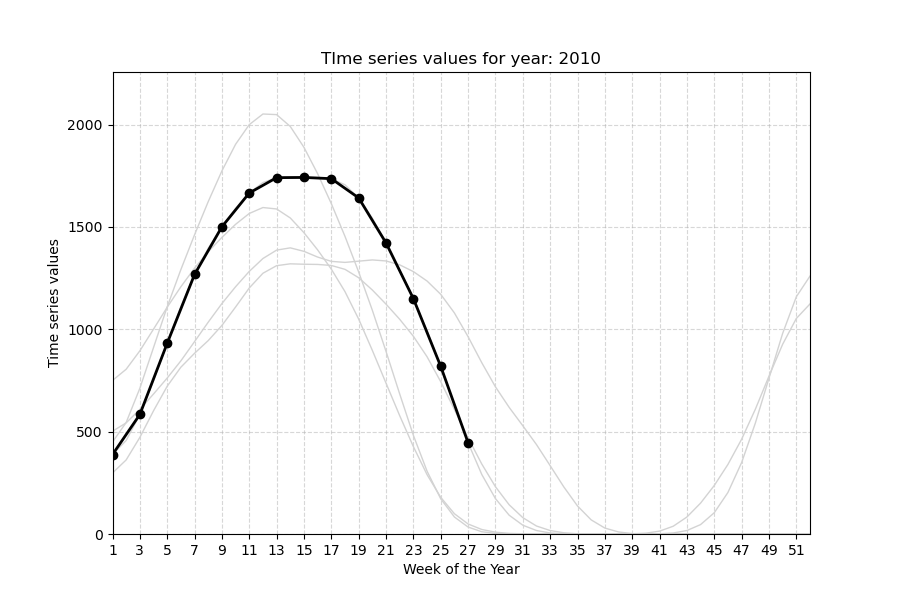

In [3]:
years = [2005, 2010, 2015, 2020, 2025]
df = generate_synthetic_ts_data(years)
ani = animate_ts(df, years_to_animate=years, week_step=2)